# Ethereum LSTM Tuning

- Very slight improvement using 'high - low' instead of seperately on very large networks
- Larger networks seem to achive much better results, but degrade rapidly
- Both small and deep networks perform poorly
- lowest lost seen `0.9177` on model1 with combined high-low

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
ethereum_df = pd.read_csv(ethereum_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
ethereum_df['datetime'] = pd.to_datetime(ethereum_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = ethereum_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = ethereum_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = ethereum_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
ethereum_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
ethereum_count                                       508
ethereum_polarity                               0.172375
ethereum_subjectivity                           0.489083
ethereum_polarity_zeros                        0.0981143
ethereum_subjectivity_zeros                     0.321798
openPriceUsd                                     1514.77
closePriceUsd                                    1520.24
highPriceUsd                                     1530.61
lowPriceUsd                                      1514.77
volume                                       44437743410
marketcap                                   174085432619
highLowDif                                       15.8376
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'ethereum_polarity_zeros', 'ethereum_subjectivity_zeros', 'openPriceUsd',  'marketcap', 'highPriceUsd', 'lowPriceUsd'])

In [5]:
timeperiod_df.iloc[0]

ethereum_count           5.080000e+02
ethereum_polarity        1.723751e-01
ethereum_subjectivity    4.890825e-01
closePriceUsd            1.520244e+03
volume                   4.443774e+10
highLowDif               1.583755e+01
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 6)
Target shape: (128, 1)


In [7]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [8]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [9]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 11s 565ms/step - loss: 0.3899 - val_loss: 6.7745
Epoch 2/20
13/13 [==============================] - 6s 482ms/step - loss: 0.2747 - val_loss: 1.7932
Epoch 3/20
13/13 [==============================] - 6s 479ms/step - loss: 0.3756 - val_loss: 1.1696
Epoch 4/20
13/13 [==============================] - 6s 489ms/step - loss: 0.3366 - val_loss: 1.1910
Epoch 5/20
13/13 [==============================] - 6s 483ms/step - loss: 0.2232 - val_loss: 7.0145
Epoch 6/20
13/13 [==============================] - 7s 528ms/step - loss: 0.1584 - val_loss: 1.0951
Epoch 7/20
13/13 [==============================] - 7s 521ms/step - loss: 0.2920 - val_loss: 1.3000
Epoch 8/20
13/13 [==============================] - 6s 481ms/step - loss: 0.1845 - val_loss: 1.0208
Epoch 9/20
13/13 [==============================] - 6s 485ms/step - loss: 0.2041 - val_loss: 1.4237
Epoch 10/20
13/13 [==============================] - 7s 518ms/step - loss: 0.1473 - val_loss: 7.103

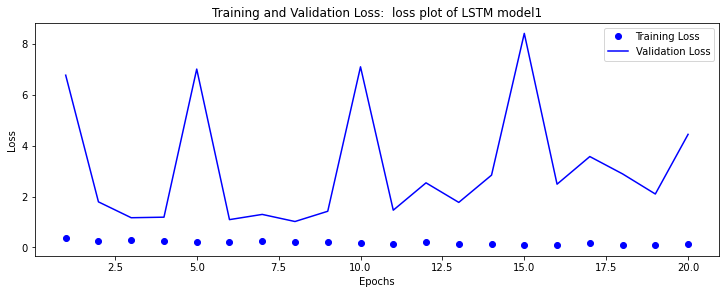

In [10]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 13s 688ms/step - loss: 0.3715 - val_loss: 2.5205
Epoch 2/20
13/13 [==============================] - 7s 549ms/step - loss: 0.4049 - val_loss: 1.5550
Epoch 3/20
13/13 [==============================] - 9s 676ms/step - loss: 0.5278 - val_loss: 1.1342
Epoch 4/20
13/13 [==============================] - 7s 549ms/step - loss: 0.3229 - val_loss: 1.1112
Epoch 5/20
13/13 [==============================] - 9s 673ms/step - loss: 0.2898 - val_loss: 1.0151
Epoch 6/20
13/13 [==============================] - 8s 666ms/step - loss: 0.2671 - val_loss: 1.2560
Epoch 7/20
13/13 [==============================] - 6s 499ms/step - loss: 0.2302 - val_loss: 6.0598
Epoch 8/20
13/13 [==============================] - 9s 671ms/step - loss: 0.1554 - val_loss: 3.8326
Epoch 9/20
13/13 [==============================] - 8s 662ms/step - loss: 0.1715 - val_loss: 3.3450
Epoch 10/20
13/13 [==============================] - 8s 659ms/step - loss: 0.1482 - val_loss: 2.457

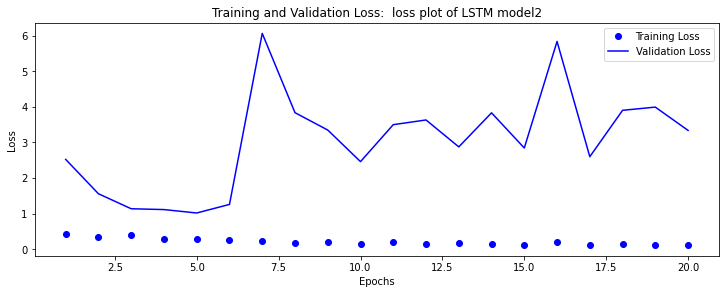

In [11]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 12s 625ms/step - loss: 0.3622 - val_loss: 3.8745
Epoch 2/20
13/13 [==============================] - 6s 445ms/step - loss: 0.5437 - val_loss: 3.8580
Epoch 3/20
13/13 [==============================] - 7s 580ms/step - loss: 0.3405 - val_loss: 3.5757
Epoch 4/20
13/13 [==============================] - 6s 442ms/step - loss: 0.2933 - val_loss: 3.3030
Epoch 5/20
13/13 [==============================] - 7s 515ms/step - loss: 0.2571 - val_loss: 3.1360
Epoch 6/20
13/13 [==============================] - 6s 459ms/step - loss: 0.2199 - val_loss: 3.5020
Epoch 7/20
13/13 [==============================] - 5s 360ms/step - loss: 0.1750 - val_loss: 6.1790
Epoch 8/20
13/13 [==============================] - 5s 410ms/step - loss: 0.1359 - val_loss: 4.6356
Epoch 9/20
13/13 [==============================] - 6s 464ms/step - loss: 0.1425 - val_loss: 3.9020
Epoch 10/20
13/13 [==============================] - 6s 479ms/step - loss: 0.1460 - val_loss: 4.780

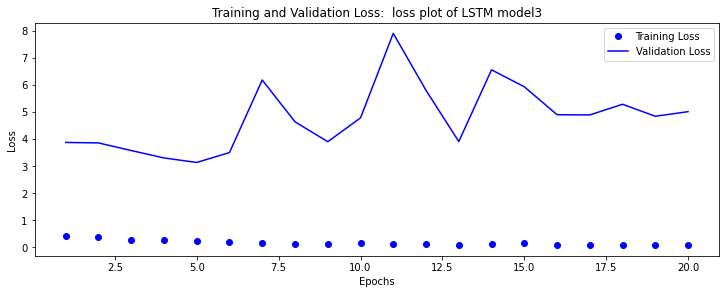

In [12]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 11s 562ms/step - loss: 0.4479 - val_loss: 2.7323
Epoch 2/20
13/13 [==============================] - 6s 437ms/step - loss: 0.5883 - val_loss: 2.7281
Epoch 3/20
13/13 [==============================] - 7s 520ms/step - loss: 0.3503 - val_loss: 2.7537
Epoch 4/20
13/13 [==============================] - 7s 575ms/step - loss: 0.2944 - val_loss: 2.6067
Epoch 5/20
13/13 [==============================] - 7s 513ms/step - loss: 0.2637 - val_loss: 2.3051
Epoch 6/20
13/13 [==============================] - 6s 446ms/step - loss: 0.2623 - val_loss: 2.7477
Epoch 7/20
13/13 [==============================] - 6s 485ms/step - loss: 0.1994 - val_loss: 3.1920
Epoch 8/20
13/13 [==============================] - 8s 629ms/step - loss: 0.1774 - val_loss: 7.3133
Epoch 9/20
13/13 [==============================] - 6s 490ms/step - loss: 0.1515 - val_loss: 2.5803
Epoch 10/20
13/13 [==============================] - 6s 424ms/step - loss: 0.1820 - val_loss: 7.677

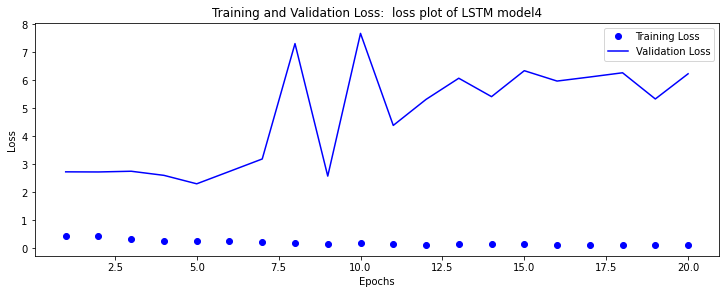

In [13]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 9s 458ms/step - loss: 0.4138 - val_loss: 7.1412
Epoch 2/30
13/13 [==============================] - 5s 368ms/step - loss: 0.4297 - val_loss: 6.2690
Epoch 3/30
13/13 [==============================] - 4s 295ms/step - loss: 0.3704 - val_loss: 6.0354
Epoch 4/30
13/13 [==============================] - 4s 295ms/step - loss: 0.3234 - val_loss: 5.8671
Epoch 5/30
13/13 [==============================] - 4s 312ms/step - loss: 0.2905 - val_loss: 5.7584
Epoch 6/30
13/13 [==============================] - 5s 400ms/step - loss: 0.2642 - val_loss: 5.6957
Epoch 7/30
13/13 [==============================] - 6s 436ms/step - loss: 0.2420 - val_loss: 5.6760
Epoch 8/30
13/13 [==============================] - 4s 334ms/step - loss: 0.2221 - val_loss: 5.7032
Epoch 9/30
13/13 [==============================] - 5s 383ms/step - loss: 0.2032 - val_loss: 5.7891
Epoch 10/30
13/13 [==============================] - 5s 404ms/step - loss: 0.1851 - val_loss: 5.9019

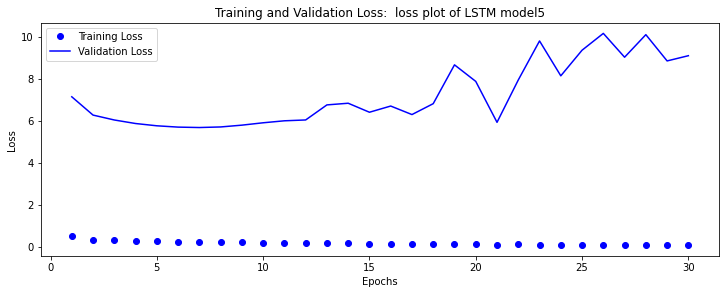

In [14]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 10s 465ms/step - loss: 0.3967 - val_loss: 6.9467
Epoch 2/20
13/13 [==============================] - 6s 487ms/step - loss: 0.4035 - val_loss: 5.1031
Epoch 3/20
13/13 [==============================] - 5s 389ms/step - loss: 0.3827 - val_loss: 4.8305
Epoch 4/20
13/13 [==============================] - 4s 311ms/step - loss: 0.3190 - val_loss: 4.5682
Epoch 5/20
13/13 [==============================] - 5s 405ms/step - loss: 0.2816 - val_loss: 4.4671
Epoch 6/20
13/13 [==============================] - 4s 309ms/step - loss: 0.2511 - val_loss: 4.2747
Epoch 7/20
13/13 [==============================] - 5s 388ms/step - loss: 0.2289 - val_loss: 4.0175
Epoch 8/20
13/13 [==============================] - 6s 439ms/step - loss: 0.2264 - val_loss: 4.2264
Epoch 9/20
13/13 [==============================] - 4s 319ms/step - loss: 0.1930 - val_loss: 3.9640
Epoch 10/20
13/13 [==============================] - 5s 377ms/step - loss: 0.1912 - val_loss: 4.370

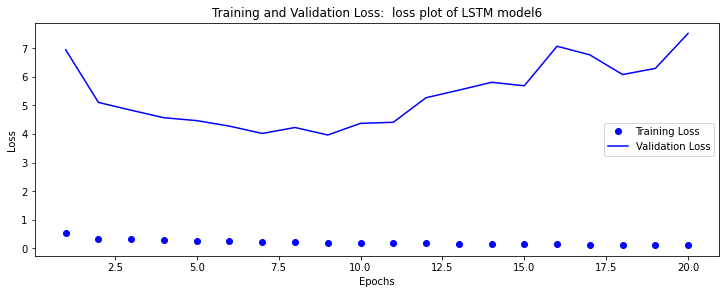

In [15]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 7s 323ms/step - loss: 0.3629 - val_loss: 11.7456
Epoch 2/30
13/13 [==============================] - 4s 289ms/step - loss: 0.2924 - val_loss: 8.7178
Epoch 3/30
13/13 [==============================] - 3s 254ms/step - loss: 0.3179 - val_loss: 8.0796
Epoch 4/30
13/13 [==============================] - 3s 240ms/step - loss: 0.2866 - val_loss: 7.7576
Epoch 5/30
13/13 [==============================] - 3s 246ms/step - loss: 0.2605 - val_loss: 7.5071
Epoch 6/30
13/13 [==============================] - 3s 232ms/step - loss: 0.2397 - val_loss: 7.2901
Epoch 7/30
13/13 [==============================] - 3s 230ms/step - loss: 0.2216 - val_loss: 7.0844
Epoch 8/30
13/13 [==============================] - 3s 225ms/step - loss: 0.2046 - val_loss: 6.8888
Epoch 9/30
13/13 [==============================] - 3s 225ms/step - loss: 0.1885 - val_loss: 6.7148
Epoch 10/30
13/13 [==============================] - 3s 227ms/step - loss: 0.1734 - val_loss: 6.558

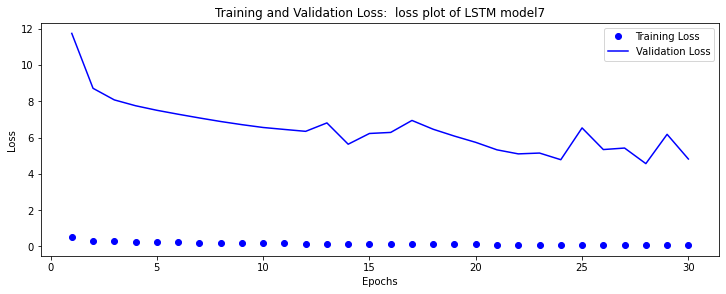

In [16]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 8s 345ms/step - loss: 0.4615 - val_loss: 8.5653
Epoch 2/20
13/13 [==============================] - 4s 338ms/step - loss: 0.3056 - val_loss: 7.0184
Epoch 3/20
13/13 [==============================] - 4s 342ms/step - loss: 0.3328 - val_loss: 6.8365
Epoch 4/20
13/13 [==============================] - 4s 354ms/step - loss: 0.3167 - val_loss: 6.6793
Epoch 5/20
13/13 [==============================] - 4s 303ms/step - loss: 0.2982 - val_loss: 6.6967
Epoch 6/20
13/13 [==============================] - 4s 347ms/step - loss: 0.2743 - val_loss: 6.4247
Epoch 7/20
13/13 [==============================] - 6s 459ms/step - loss: 0.2564 - val_loss: 6.3399
Epoch 8/20
13/13 [==============================] - 4s 273ms/step - loss: 0.2384 - val_loss: 6.4383
Epoch 9/20
13/13 [==============================] - 3s 260ms/step - loss: 0.2258 - val_loss: 6.5622
Epoch 10/20
13/13 [==============================] - 3s 259ms/step - loss: 0.2010 - val_loss: 6.3100

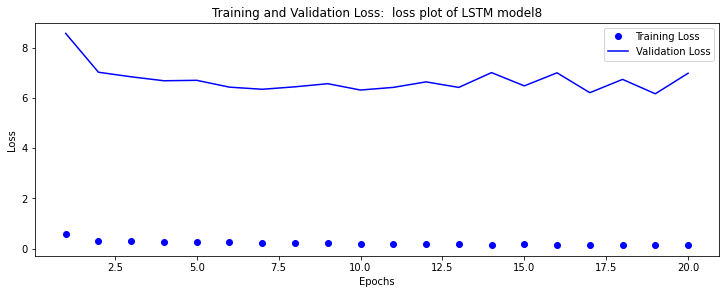

In [17]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 7s 269ms/step - loss: 0.7770 - val_loss: 14.6744
Epoch 2/30
13/13 [==============================] - 3s 259ms/step - loss: 0.3518 - val_loss: 11.1852
Epoch 3/30
13/13 [==============================] - 4s 270ms/step - loss: 0.2719 - val_loss: 9.2722
Epoch 4/30
13/13 [==============================] - 4s 308ms/step - loss: 0.2695 - val_loss: 8.5666
Epoch 5/30
13/13 [==============================] - 4s 336ms/step - loss: 0.2535 - val_loss: 8.3380
Epoch 6/30
13/13 [==============================] - 3s 223ms/step - loss: 0.2307 - val_loss: 8.2751
Epoch 7/30
13/13 [==============================] - 3s 232ms/step - loss: 0.2093 - val_loss: 8.2935
Epoch 8/30
13/13 [==============================] - 3s 272ms/step - loss: 0.1904 - val_loss: 8.3591
Epoch 9/30
13/13 [==============================] - 4s 307ms/step - loss: 0.1737 - val_loss: 8.4553
Epoch 10/30
13/13 [==============================] - 3s 215ms/step - loss: 0.1589 - val_loss: 8.56

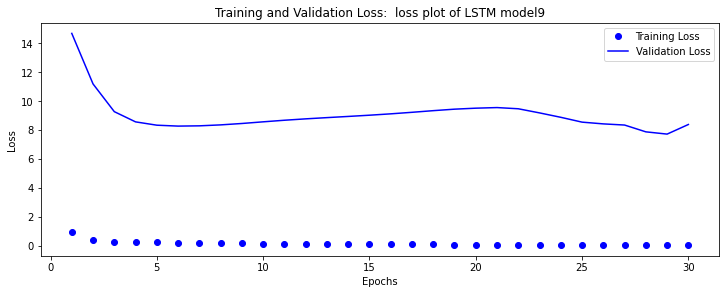

In [18]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 8s 329ms/step - loss: 0.6006 - val_loss: 16.5172
Epoch 2/20
13/13 [==============================] - 5s 386ms/step - loss: 0.3255 - val_loss: 13.1516
Epoch 3/20
13/13 [==============================] - 3s 268ms/step - loss: 0.2631 - val_loss: 10.4996
Epoch 4/20
13/13 [==============================] - 4s 300ms/step - loss: 0.2645 - val_loss: 9.0001
Epoch 5/20
13/13 [==============================] - 3s 237ms/step - loss: 0.2691 - val_loss: 8.3872
Epoch 6/20
13/13 [==============================] - 3s 267ms/step - loss: 0.2621 - val_loss: 8.0898
Epoch 7/20
13/13 [==============================] - 3s 242ms/step - loss: 0.2447 - val_loss: 7.9391
Epoch 8/20
13/13 [==============================] - 4s 284ms/step - loss: 0.2228 - val_loss: 7.8021
Epoch 9/20
13/13 [==============================] - 4s 308ms/step - loss: 0.2097 - val_loss: 7.7819
Epoch 10/20
13/13 [==============================] - 3s 243ms/step - loss: 0.1870 - val_loss: 7.8

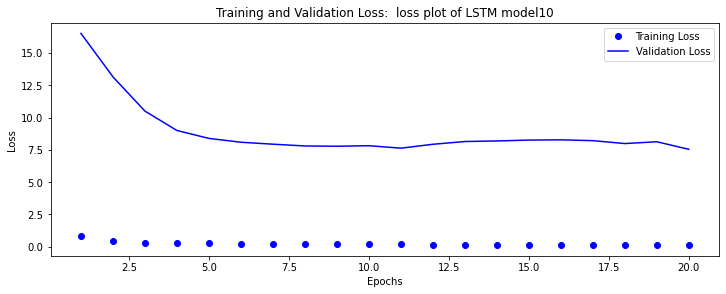

In [19]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 6s 263ms/step - loss: 0.9192 - val_loss: 24.4005
Epoch 2/50
13/13 [==============================] - 3s 217ms/step - loss: 0.7912 - val_loss: 23.3748
Epoch 3/50
13/13 [==============================] - 4s 273ms/step - loss: 0.7315 - val_loss: 22.3306
Epoch 4/50
13/13 [==============================] - 3s 256ms/step - loss: 0.6695 - val_loss: 21.2117
Epoch 5/50
13/13 [==============================] - 3s 219ms/step - loss: 0.6211 - val_loss: 20.0807
Epoch 6/50
13/13 [==============================] - 3s 219ms/step - loss: 0.5681 - val_loss: 18.9798
Epoch 7/50
13/13 [==============================] - 3s 252ms/step - loss: 0.5221 - val_loss: 17.9604
Epoch 8/50
13/13 [==============================] - 5s 308ms/step - loss: 0.4889 - val_loss: 17.0300
Epoch 9/50
13/13 [==============================] - 4s 327ms/step - loss: 0.4554 - val_loss: 16.2091
Epoch 10/50
13/13 [==============================] - 3s 204ms/step - loss: 0.4313 - val_los

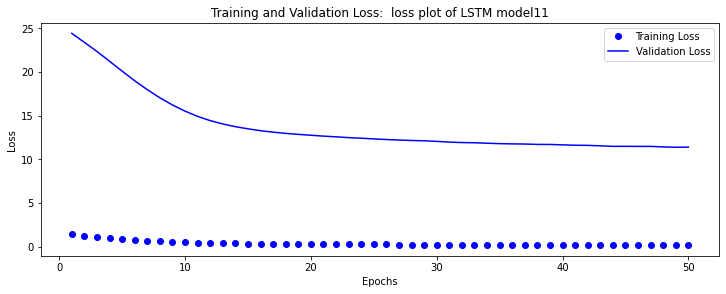

In [20]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 12s 578ms/step - loss: 0.5097 - val_loss: 5.6614
Epoch 2/20
13/13 [==============================] - 7s 579ms/step - loss: 0.6522 - val_loss: 5.4601
Epoch 3/20
13/13 [==============================] - 7s 554ms/step - loss: 0.4950 - val_loss: 4.9015
Epoch 4/20
13/13 [==============================] - 6s 485ms/step - loss: 0.4217 - val_loss: 4.3790
Epoch 5/20
13/13 [==============================] - 8s 637ms/step - loss: 0.3675 - val_loss: 4.0609
Epoch 6/20
13/13 [==============================] - 7s 525ms/step - loss: 0.3301 - val_loss: 3.7086
Epoch 7/20
13/13 [==============================] - 7s 515ms/step - loss: 0.2970 - val_loss: 3.8949
Epoch 8/20
13/13 [==============================] - 7s 518ms/step - loss: 0.2435 - val_loss: 4.6232
Epoch 9/20
13/13 [==============================] - 7s 530ms/step - loss: 0.1848 - val_loss: 6.2702
Epoch 10/20
13/13 [==============================] - 9s 674ms/step - loss: 0.1629 - val_loss: 8.500

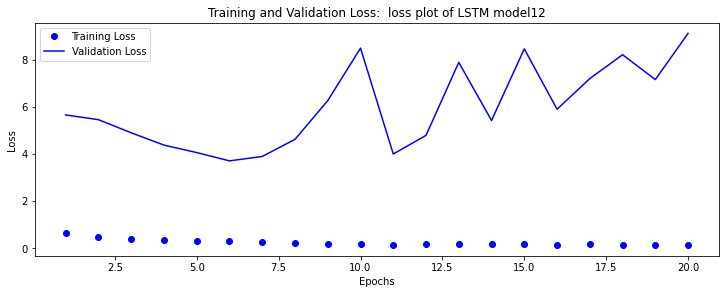

In [21]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 19s 759ms/step - loss: 0.5023 - val_loss: 4.3256
Epoch 2/20
13/13 [==============================] - 9s 717ms/step - loss: 0.6659 - val_loss: 3.7061
Epoch 3/20
13/13 [==============================] - 9s 701ms/step - loss: 0.6683 - val_loss: 3.7844
Epoch 4/20
13/13 [==============================] - 9s 715ms/step - loss: 0.4626 - val_loss: 3.3602
Epoch 5/20
13/13 [==============================] - 8s 664ms/step - loss: 0.3746 - val_loss: 3.0465
Epoch 6/20
13/13 [==============================] - 9s 707ms/step - loss: 0.3039 - val_loss: 2.7706
Epoch 7/20
13/13 [==============================] - 9s 698ms/step - loss: 0.2623 - val_loss: 5.7944
Epoch 8/20
13/13 [==============================] - 12s 959ms/step - loss: 0.1735 - val_loss: 5.2771
Epoch 9/20
13/13 [==============================] - 8s 664ms/step - loss: 0.1913 - val_loss: 4.2743
Epoch 10/20
13/13 [==============================] - 9s 683ms/step - loss: 0.1740 - val_loss: 5.66

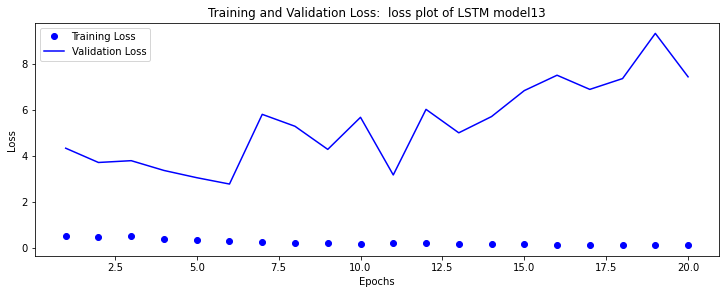

In [22]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 8s 331ms/step - loss: 0.3550 - val_loss: 7.4481
Epoch 2/20
13/13 [==============================] - 4s 287ms/step - loss: 0.4484 - val_loss: 6.0258
Epoch 3/20
13/13 [==============================] - 4s 283ms/step - loss: 0.3478 - val_loss: 5.5922
Epoch 4/20
13/13 [==============================] - 5s 396ms/step - loss: 0.2950 - val_loss: 5.3336
Epoch 5/20
13/13 [==============================] - 4s 351ms/step - loss: 0.2613 - val_loss: 5.1728
Epoch 6/20
13/13 [==============================] - 4s 302ms/step - loss: 0.2345 - val_loss: 5.0947
Epoch 7/20
13/13 [==============================] - 4s 288ms/step - loss: 0.2107 - val_loss: 5.0943
Epoch 8/20
13/13 [==============================] - 4s 316ms/step - loss: 0.1883 - val_loss: 5.1486
Epoch 9/20
13/13 [==============================] - 4s 287ms/step - loss: 0.1682 - val_loss: 5.3612
Epoch 10/20
13/13 [==============================] - 4s 275ms/step - loss: 0.1540 - val_loss: 6.4308

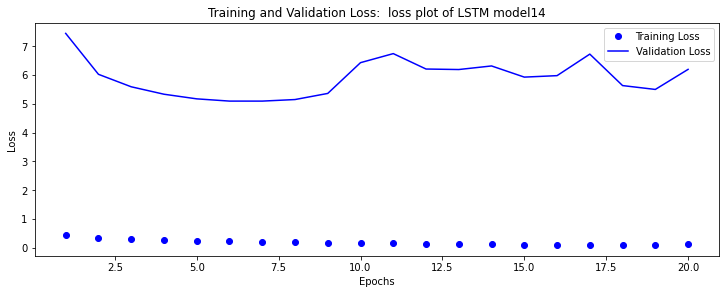

In [23]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 7s 332ms/step - loss: 0.5685 - val_loss: 16.2823
Epoch 2/40
13/13 [==============================] - 3s 225ms/step - loss: 0.3760 - val_loss: 13.8838
Epoch 3/40
13/13 [==============================] - 3s 244ms/step - loss: 0.3170 - val_loss: 12.2447
Epoch 4/40
13/13 [==============================] - 3s 217ms/step - loss: 0.3050 - val_loss: 11.2180
Epoch 5/40
13/13 [==============================] - 3s 206ms/step - loss: 0.3056 - val_loss: 10.5754
Epoch 6/40
13/13 [==============================] - 3s 212ms/step - loss: 0.3039 - val_loss: 10.1602
Epoch 7/40
13/13 [==============================] - 3s 214ms/step - loss: 0.2962 - val_loss: 9.8808
Epoch 8/40
13/13 [==============================] - 2s 189ms/step - loss: 0.2834 - val_loss: 9.6786
Epoch 9/40
13/13 [==============================] - 3s 213ms/step - loss: 0.2680 - val_loss: 9.5184
Epoch 10/40
13/13 [==============================] - 3s 258ms/step - loss: 0.2519 - val_loss: 

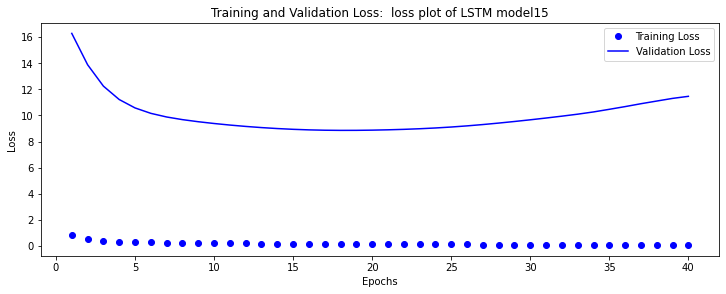

In [24]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 9s 431ms/step - loss: 0.4815 - val_loss: 5.5815
Epoch 2/20
13/13 [==============================] - 5s 381ms/step - loss: 0.6272 - val_loss: 5.3118
Epoch 3/20
13/13 [==============================] - 6s 484ms/step - loss: 0.4071 - val_loss: 4.5238
Epoch 4/20
13/13 [==============================] - 4s 335ms/step - loss: 0.3289 - val_loss: 4.0314
Epoch 5/20
13/13 [==============================] - 4s 341ms/step - loss: 0.2674 - val_loss: 3.8828
Epoch 6/20
13/13 [==============================] - 6s 441ms/step - loss: 0.2190 - val_loss: 4.0531
Epoch 7/20
13/13 [==============================] - 8s 605ms/step - loss: 0.1814 - val_loss: 4.8212
Epoch 8/20
13/13 [==============================] - 4s 321ms/step - loss: 0.1524 - val_loss: 7.4674
Epoch 9/20
13/13 [==============================] - 5s 401ms/step - loss: 0.1365 - val_loss: 2.2431
Epoch 10/20
13/13 [==============================] - 4s 337ms/step - loss: 0.1787 - val_loss: 9.1551

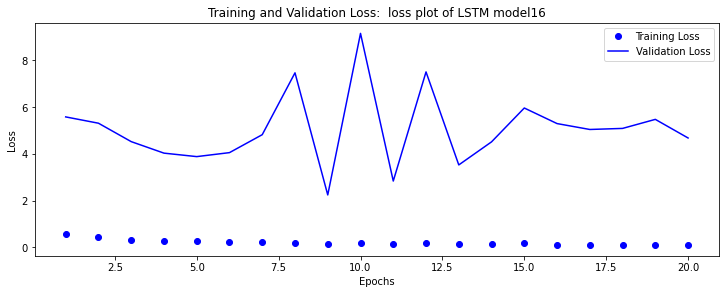

In [25]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 13s 537ms/step - loss: 0.6637 - val_loss: 12.1070
Epoch 2/30
13/13 [==============================] - 5s 394ms/step - loss: 0.4490 - val_loss: 7.4861
Epoch 3/30
13/13 [==============================] - 5s 392ms/step - loss: 0.5843 - val_loss: 6.7359
Epoch 4/30
13/13 [==============================] - 5s 391ms/step - loss: 0.5406 - val_loss: 6.2507
Epoch 5/30
13/13 [==============================] - 5s 378ms/step - loss: 0.4642 - val_loss: 5.8439
Epoch 6/30
13/13 [==============================] - 6s 482ms/step - loss: 0.3881 - val_loss: 5.5767
Epoch 7/30
13/13 [==============================] - 6s 449ms/step - loss: 0.3195 - val_loss: 5.4895
Epoch 8/30
13/13 [==============================] - 6s 505ms/step - loss: 0.2629 - val_loss: 5.5998
Epoch 9/30
13/13 [==============================] - 5s 385ms/step - loss: 0.2201 - val_loss: 5.8931
Epoch 10/30
13/13 [==============================] - 5s 419ms/step - loss: 0.1893 - val_loss: 6.28

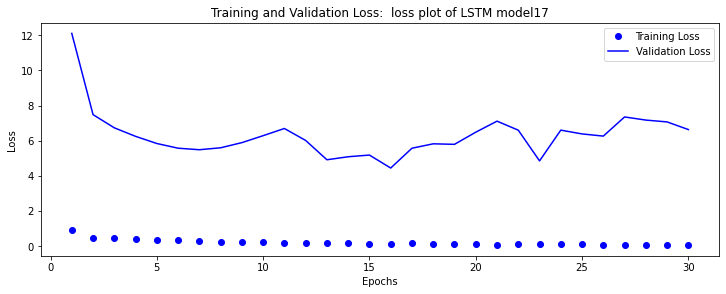

In [26]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 13s 465ms/step - loss: 0.5433 - val_loss: 14.7707
Epoch 2/30
13/13 [==============================] - 5s 373ms/step - loss: 0.3271 - val_loss: 10.6797
Epoch 3/30
13/13 [==============================] - 5s 374ms/step - loss: 0.4175 - val_loss: 9.6330
Epoch 4/30
13/13 [==============================] - 5s 400ms/step - loss: 0.4174 - val_loss: 9.2551
Epoch 5/30
13/13 [==============================] - 5s 380ms/step - loss: 0.3740 - val_loss: 9.1603
Epoch 6/30
13/13 [==============================] - 4s 333ms/step - loss: 0.3214 - val_loss: 9.1981
Epoch 7/30
13/13 [==============================] - 4s 328ms/step - loss: 0.2708 - val_loss: 9.2805
Epoch 8/30
13/13 [==============================] - 4s 319ms/step - loss: 0.2296 - val_loss: 9.3382
Epoch 9/30
13/13 [==============================] - 4s 338ms/step - loss: 0.1982 - val_loss: 9.4074
Epoch 10/30
13/13 [==============================] - 5s 375ms/step - loss: 0.1724 - val_loss: 9.5

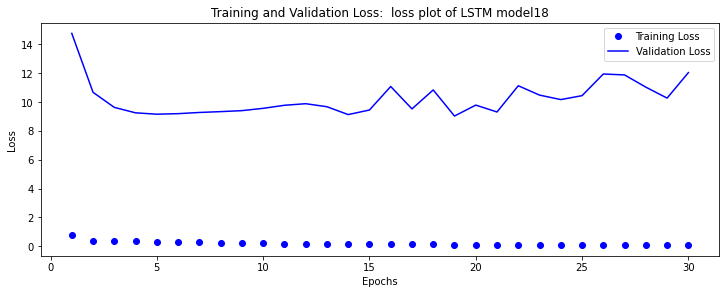

In [27]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [28]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 1.0208369493484497, epoch: 8
Model 2: min val loss: 1.0151393413543701, epoch: 5
Model 3: min val loss: 3.1360018253326416, epoch: 5
Model 4: min val loss: 2.305053234100342, epoch: 5
Model 5: min val loss: 5.675978183746338, epoch: 7
Model 6: min val loss: 3.96398663520813, epoch: 9
Model 7: min val loss: 4.566281318664551, epoch: 28
Model 8: min val loss: 6.1607513427734375, epoch: 19
Model 9: min val loss: 7.722813129425049, epoch: 29
Model 10: min val loss: 7.542097091674805, epoch: 20
Model 11: min val loss: 11.36477279663086, epoch: 49
Model 12: min val loss: 3.7085859775543213, epoch: 6
Model 13: min val loss: 2.7705698013305664, epoch: 6
Model 14: min val loss: 5.0943450927734375, epoch: 7
Model 15: min val loss: 8.855920791625977, epoch: 18
Model 16: min val loss: 2.243072748184204, epoch: 9
Model 17: min val loss: 4.447903156280518, epoch: 16
Model 18: min val loss: 9.032678604125977, epoch: 19
